### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [1]:
!pip install biopython
!pip install plotnine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.5 MB/s eta 0:00:00


**1.2 | Import Required Packages**

In [2]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
from    plotnine import *
from    mizani.formatters import comma_format, percent_format

### 🚰  2 | Query PubMed API for Publication Counts
---

In [6]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    """
    Fetches publication counts from PubMed for multiple search terms over a range of years.

    :param search_terms: Dictionary of search terms (diseases) and their PubMed query strings.
    :param start_year: Start year for the data collection.
    :param end_year: End year for the data collection.
    :return: DataFrame with years as rows and diseases as columns, containing publication counts.
    """
    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)
    Entrez.email = "rory@eudemo.co"

    for year in years:
        for term, query in search_terms.items():
            # Constructing the query with the search term and year
            full_query = f"{query} AND ({year}[Date - Publication])"
            try:
                handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
                record = Entrez.read(handle)
                count = int(record.get("Count", 0))
                publication_counts[term].append(count)
                handle.close()
            except Exception as e:
                print(f"Error fetching data for {term} in {year}: {e}")
                publication_counts[term].append(None)  # Append None to indicate failure for this year

    # Creating a DataFrame from the collected data
    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

# Updated search terms
search_terms = {
    "Long Covid Only": (
        '(("Long Covid" '
        'OR "Post-COVID Syndrome" '
        'OR "Long-Haul COVID" '
        'OR "Post-acute sequelae of COVID-19" '
        'OR "PASC" '
        'OR "Post-COVID-19 condition") '
        'NOT ("ME/CFS" '
        'OR "Myalgic Encephalomyelitis" '
        'OR "Chronic Fatigue Syndrome" '
        'OR "Systemic Exertion Intolerance Disease"))'
    ),
    "Long Covid & ME/CFS": (
        '(("Long Covid" '
        'OR "Post-COVID Syndrome" '
        'OR "Long-Haul COVID" '
        'OR "Post-acute sequelae of COVID-19" '
        'OR "PASC" '
        'OR "Post-COVID-19 condition") '
        'AND ("ME/CFS" '
        'OR "Myalgic Encephalomyelitis" '
        'OR "Chronic Fatigue Syndrome" '
        'OR "Systemic Exertion Intolerance Disease"))'
    )
}

# Define the start and end years for the search
start_year = 2020
end_year = 2024

# Fetching the data
publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.tail()

,Long Covid Only,Long Covid & ME/CFS
Year,,
2020,77,4
2021,830,52
2022,2128,114
2023,2627,128
2024,2678,130


In [7]:
# Transforming the DataFrame to long format
long_df = publications_df.reset_index().melt(id_vars='Year', var_name='Disease', value_name='Publications')

# Calculate the total publications per year for normalization
long_df['Total'] = long_df.groupby('Year')['Publications'].transform('sum')

# Calculate the percentage of publications for each category per year
long_df['Percentage'] = 100 * long_df['Publications'] / long_df['Total']

# Check result
long_df

,Year,Disease,Publications,Total,Percentage
0,2020,Long Covid Only,77,81,95.061728
1,2021,Long Covid Only,830,882,94.104308
2,2022,Long Covid Only,2128,2242,94.915254
3,2023,Long Covid Only,2627,2755,95.353902
4,2024,Long Covid Only,2678,2808,95.370370
5,2020,Long Covid & ME/CFS,4,81,4.938272
6,2021,Long Covid & ME/CFS,52,882,5.895692
7,2022,Long Covid & ME/CFS,114,2242,5.084746
8,2023,Long Covid & ME/CFS,128,2755,4.646098
9,2024,Long Covid & ME/CFS,130,2808,4.629630


### 📈  3 | Visualise Results
---

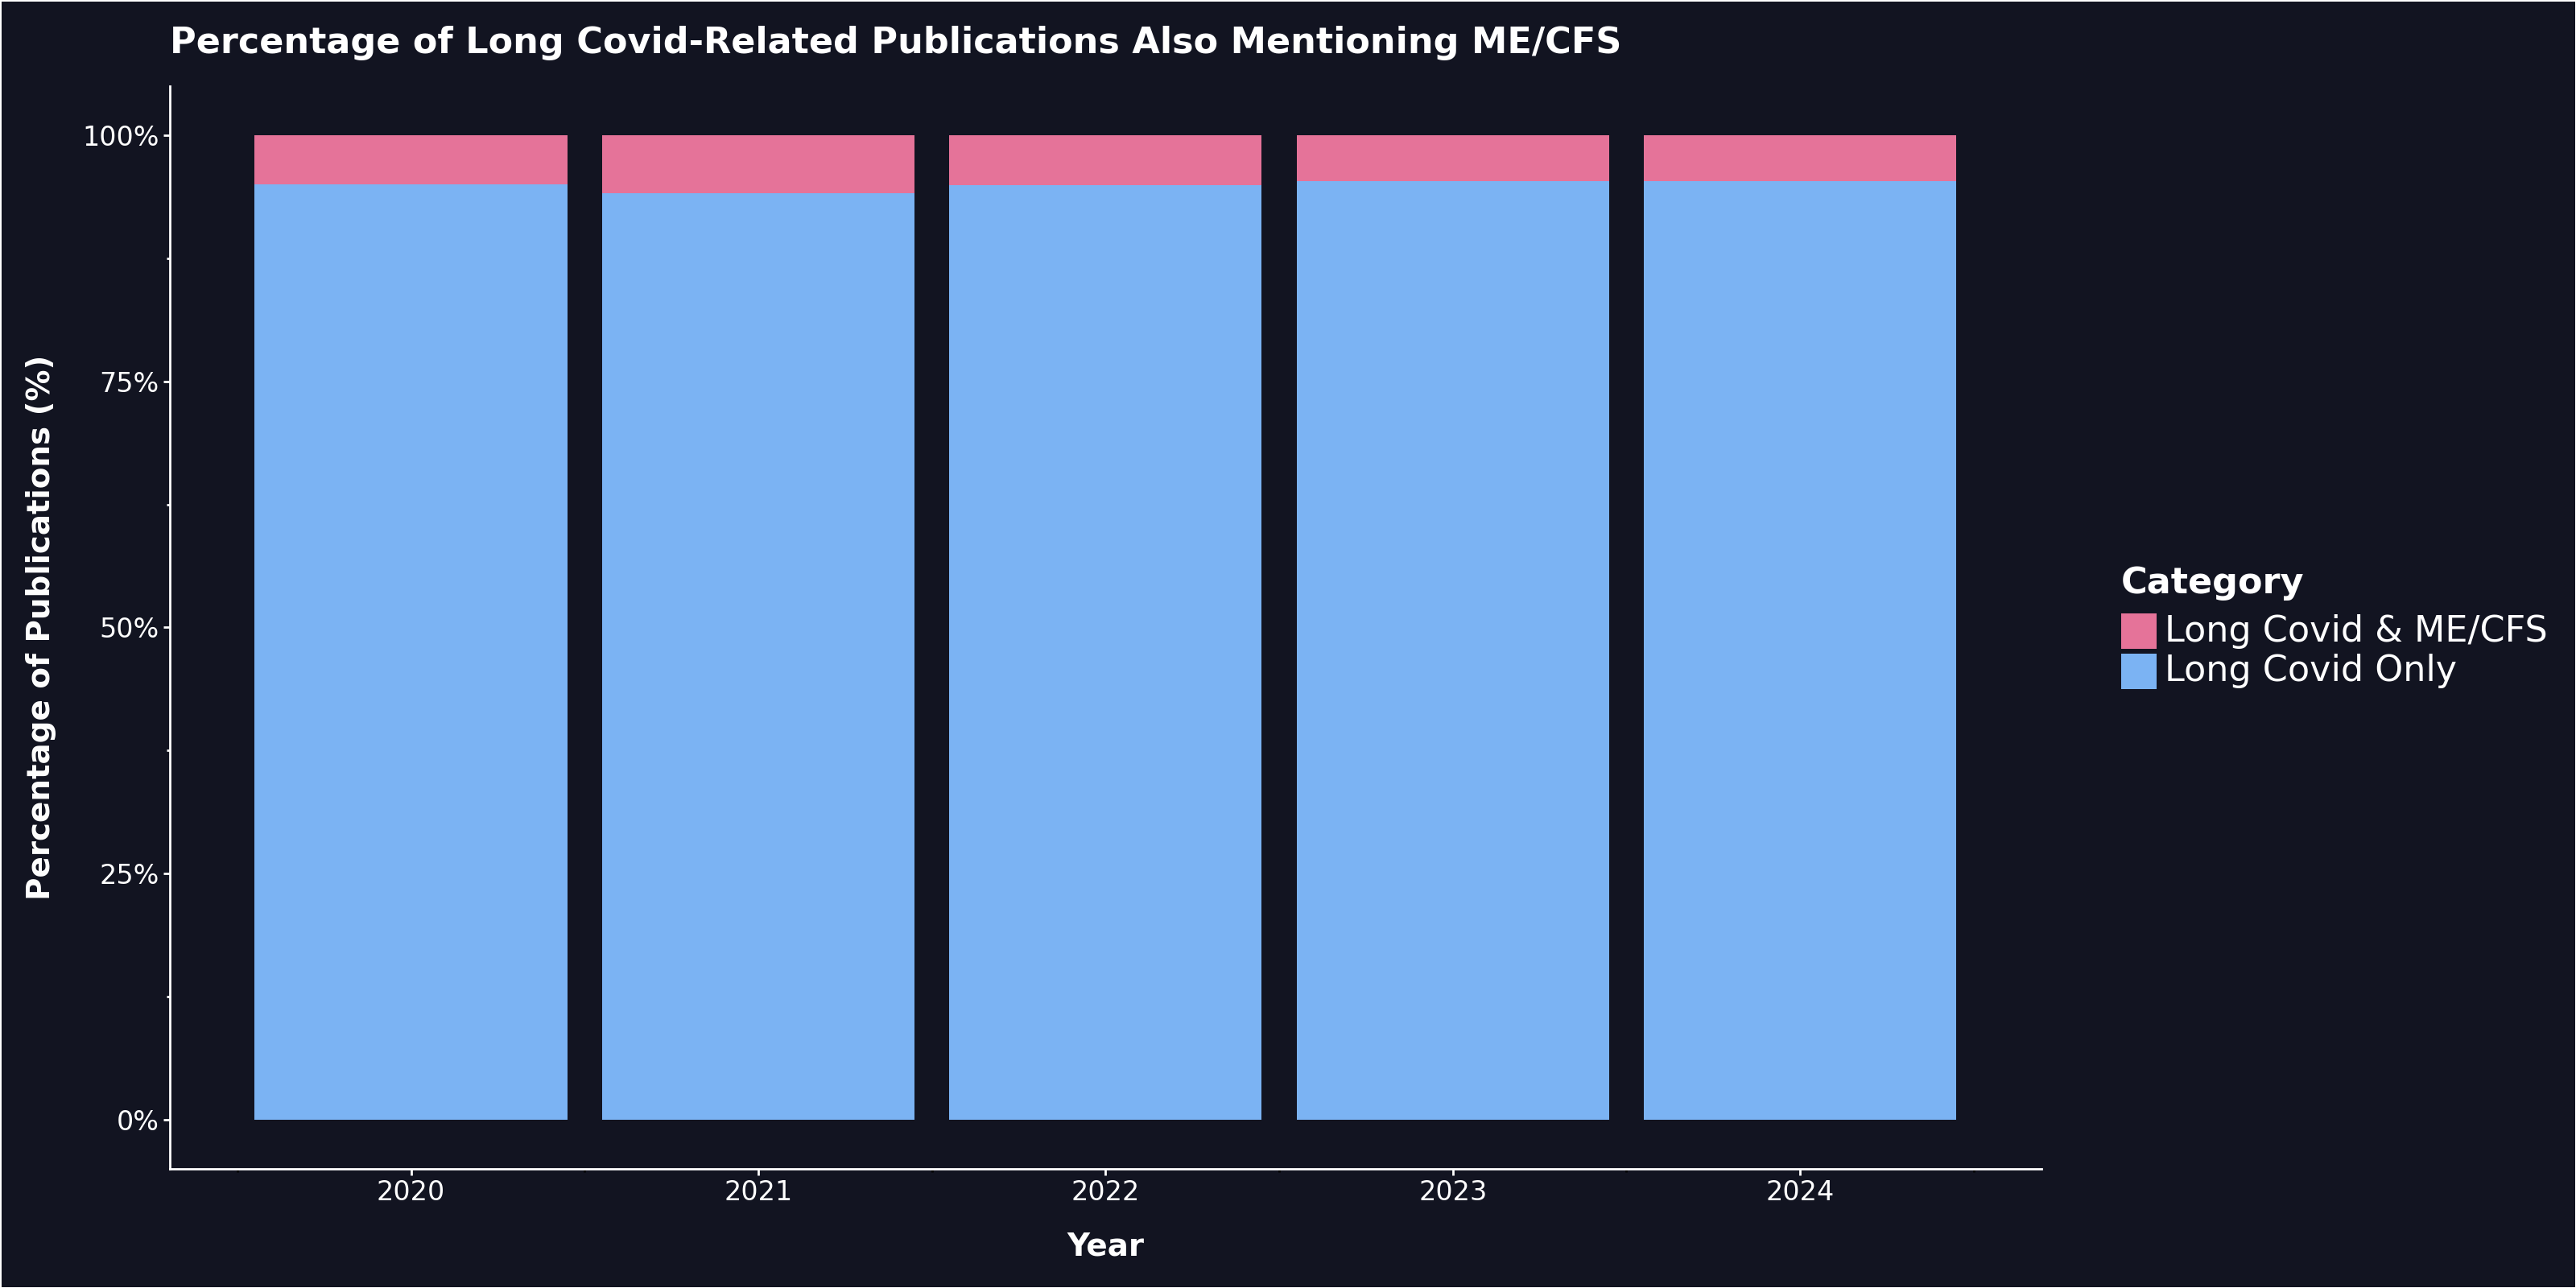

In [8]:
# Create a percentage stacked bar chart using plotnine, with y-axis as percentages
plot = (ggplot(long_df, aes(x='Year', y='Percentage', fill='Disease'))
        + geom_bar(stat='identity', position='fill')  # Stacks percentage for each category
        + labs(x='Year', y='Percentage of Publications (%)', fill='Category', title='Percentage of Long Covid-Related Publications Also Mentioning ME/CFS')
        + scale_y_continuous(labels=percent_format())  # Convert y-axis to percentage format
        + scale_fill_manual(values=['#E57399', '#7BB3F3'])
        + theme_classic()
        + theme(
            figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold', color='white'),
            axis_text=element_text(size=12, color='white'),
            plot_title=element_text(size=16, weight='bold', color='white', hjust=0),
            legend_title=element_text(size=16, weight='bold', color='white'),
            legend_text=element_text(size=16, color='white'),
            plot_background=element_rect(fill='#121421', color=None),
            panel_background=element_rect(fill='#121421', color=None),
            legend_background=element_rect(fill='#121421', color=None),
            legend_key=element_rect(fill='#121421', color=None),
            axis_line=element_line(color='white', size=1),
            axis_ticks=element_line(color='white', size=1)
            )
)

# Display the plot
plot